In [1]:
%matplotlib inline

from keras.datasets import cifar10
from keras.models import Sequential
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

[6]


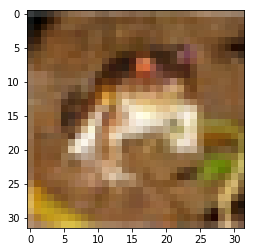

In [3]:
plt.imshow(X_train[0]); print(y_train[0])

In [4]:
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten

model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=X_train.shape[1:]))  # FIXME stride == subsample
model.add(Activation("relu"))
model.add(Convolution2D(32, 3, 3))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation("softmax"))

In [5]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
from keras.utils import np_utils

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [ ]:
model.fit(X_train, Y_train,
          batch_size=32,
          nb_epoch=200,
          validation_data=(X_test, Y_test),
          shuffle=True,
          verbose=2)

Train on 50000 samples, validate on 10000 samples
Epoch 1/200
14s - loss: 1.3922 - acc: 0.5080 - val_loss: 1.1430 - val_acc: 0.5998
Epoch 2/200
14s - loss: 1.0532 - acc: 0.6377 - val_loss: 1.2006 - val_acc: 0.5876
Epoch 3/200
14s - loss: 0.9419 - acc: 0.6763 - val_loss: 1.0130 - val_acc: 0.6540
Epoch 4/200
14s - loss: 0.8712 - acc: 0.7019 - val_loss: 0.9668 - val_acc: 0.6748
Epoch 5/200
14s - loss: 0.8192 - acc: 0.7219 - val_loss: 0.9894 - val_acc: 0.6627
Epoch 6/200
14s - loss: 0.7764 - acc: 0.7369 - val_loss: 1.0598 - val_acc: 0.6563
Epoch 7/200
15s - loss: 0.7382 - acc: 0.7511 - val_loss: 0.9724 - val_acc: 0.6732
Epoch 8/200
14s - loss: 0.7064 - acc: 0.7618 - val_loss: 1.0276 - val_acc: 0.6691
Epoch 9/200
14s - loss: 0.6763 - acc: 0.7721 - val_loss: 1.0075 - val_acc: 0.6732
Epoch 10/200
13s - loss: 0.6506 - acc: 0.7818 - val_loss: 1.0990 - val_acc: 0.6571
Epoch 11/200
14s - loss: 0.6254 - acc: 0.7914 - val_loss: 1.0592 - val_acc: 0.6584
Epoch 12/200
14s - loss: 0.6029 - acc: 0.7972 